# EDA

PLETH 데이터가 다양한 모델의 Layer 를 적용할 때 어느정도 유의미할 것으로 생각되는지 Component-by-Component로 확인해보자.

In [1]:
import gzip
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from utils.signal_processing import *
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '/root/Workspace/DataWarehouse/stMary_RRpo'

with gzip.open(f'{DATA_PATH}/21_230518_resamp_sliced125_filt_patient_stmary.pickle.gzip', 'rb') as f:
    dataset = pickle.load(f)

print(len(dataset), len(dataset[0][0]))

random.seed(42)
random.shuffle(dataset)

pleths = []
resps = []
for ppg, rr in dataset:
    pleths.append(ppg.astype(np.float64))
    resps.append(rr)

pleths = np.asarray(pleths)
resps = np.asarray(resps)
print(pleths.shape, resps.shape)

scaler = MinMaxScaler()
scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))

ratio_tr = 0.8
train_x, train_y = scaled_pleths[:int(len(scaled_pleths)*ratio_tr)], resps[:int(len(resps)*ratio_tr)]
val_x, val_y = scaled_pleths[int(len(scaled_pleths)*ratio_tr):], resps[int(len(resps)*ratio_tr):]
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

6508 1800
(6508, 1800) (6508,)
(6508, 1800, 1) <class 'numpy.float64'>
(5206, 1800, 1) (5206,)
(1302, 1800, 1) (1302,)


In [2]:
import tensorflow as tf
from keras.layers import AveragePooling1D, MaxPooling1D, Conv1D

test = train_x[0].reshape(1,-1,1)
print(test.shape)

2023-05-24 11:45:51.804133: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-24 11:45:51.848533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 11:45:52.522867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(1, 1800, 1)


## Pooling to PPG

In [3]:
test_avg2s2 = AveragePooling1D(pool_size=2, strides=2, padding='same')(test)
test_max2s2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(test)
print(test_avg2s2.shape, test_max2s2.shape)

2023-05-24 11:45:54.062579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14369 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


(1, 900, 1) (1, 900, 1)


2023-05-24 11:45:55.035361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


In [4]:
test2_avg2s2 = AveragePooling1D(pool_size=2, strides=2, padding='same')(test_avg2s2)
test2_max2s2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(test_max2s2)
print(test2_avg2s2.shape, test2_max2s2.shape)

(1, 450, 1) (1, 450, 1)


In [5]:
test_avg3s2 = AveragePooling1D(pool_size=3, strides=2, padding='same')(test)
test_max3s2 = MaxPooling1D(pool_size=3, strides=2, padding='same')(test)
print(test_avg3s2.shape, test_max3s2.shape)

(1, 900, 1) (1, 900, 1)


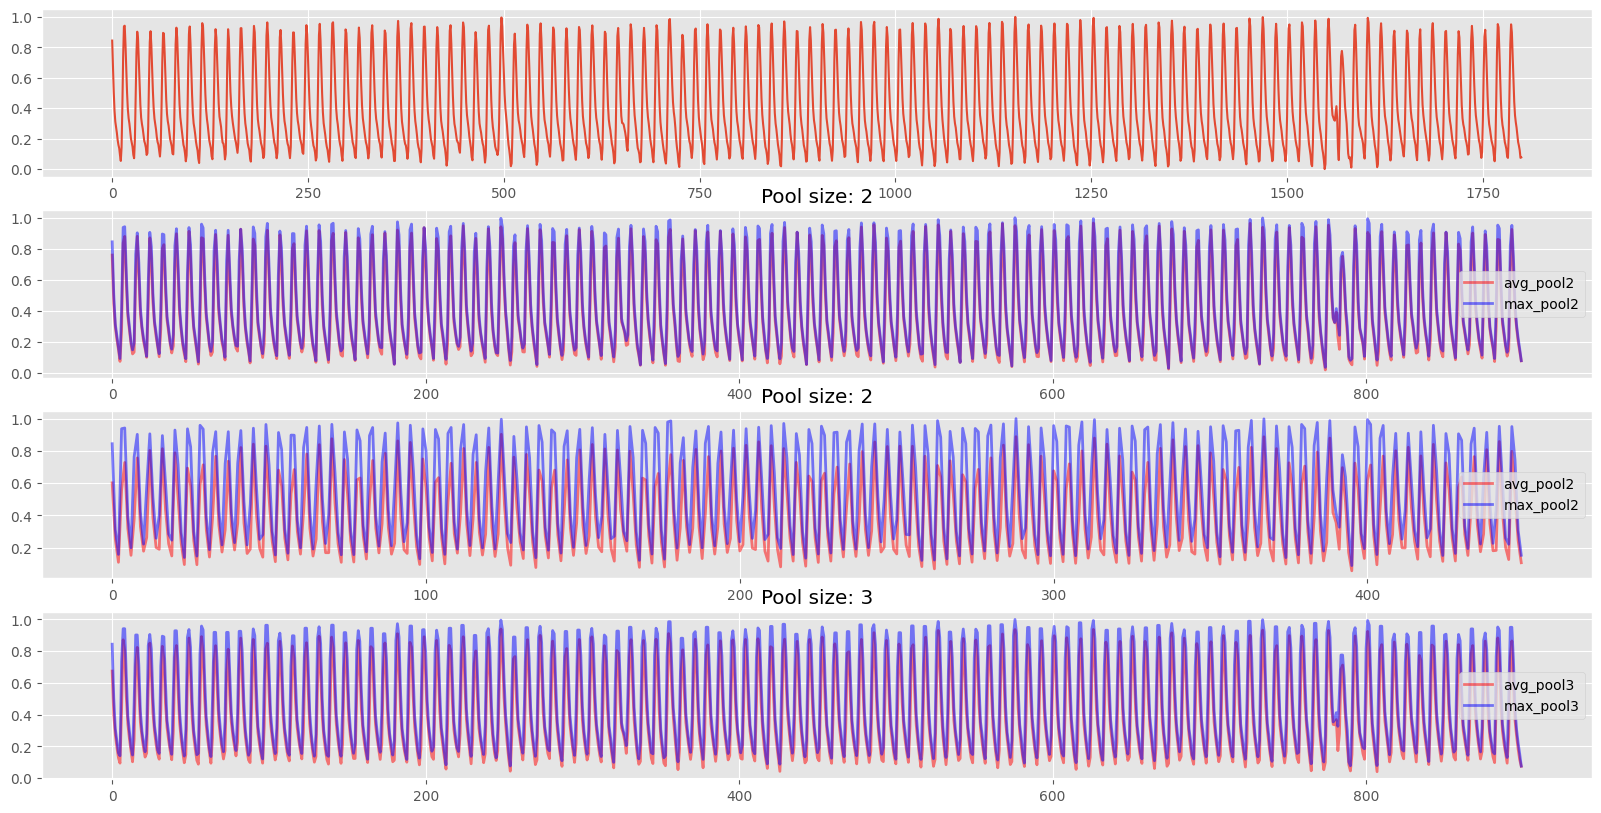

In [6]:
fig, axs = plt.subplots(4,1,figsize=(20,10))
axs[0].plot(test.reshape(-1))
axs[1].plot(tf.reshape(test_avg2s2, [-1]), alpha=.5, color='r', linewidth=2, label='avg_pool2')
axs[1].plot(tf.reshape(test_max2s2, [-1]), alpha=.5, color='b', linewidth=2, label='max_pool2')
axs[1].legend()
axs[1].set_title('Pool size: 2')
axs[2].plot(tf.reshape(test2_avg2s2, [-1]), alpha=.5, color='r', linewidth=2, label='avg_pool2')
axs[2].plot(tf.reshape(test2_max2s2, [-1]), alpha=.5, color='b', linewidth=2, label='max_pool2')
axs[2].legend()
axs[2].set_title('Pool size: 2')
axs[3].plot(tf.reshape(test_avg3s2, [-1]), alpha=.5, color='r', linewidth=2, label='avg_pool3')
axs[3].plot(tf.reshape(test_max3s2, [-1]), alpha=.5, color='b', linewidth=2, label='max_pool3')
axs[3].legend()
axs[3].set_title('Pool size: 3')
plt.show()

Maxpooling 이나 Averagepooling 어느 쪽을 사용해도 문제가 존재한다.

왜냐하면 호흡수를 예측하기 위해 제시되는 세 가지 변수로는 대표적으로 RIIV, RIFV, RIAV 가 있는데 Pooling을 사용하면 PPG의 본래 형태학적인 특징 중 Valley 또는 Peak 값이 손실되기 때문이다. 

아래 그림의 2, 3번째 행 그림을 확인해보면, Max를 사용하면 Peak를 살리지만 Valley가 훼손되고, Avg를 사용하면 Valley를 살리지만 Peak가 훼손되는 것을 볼 수 있다.

이는 미세한 차이지만, 그 미세한 차이가 어떤 나비효과를 불러올지 모른다면 이는 주의를 요할 필요가 있어 보인다.

그러므로 Downsampling 용도로서 Convolution을 사용하는 쪽이 어떨까 생각된다. 이는 온전한 기존 데이터로부터 특징을 추출해내는 방식이기 때문에 원본의 형상이 훼손되지 않는다. 

물론 Pooling은 데이터로부터 비롯되는 파라메터의 수를 줄여주고, 과적합을 방지한다는 측면이 존재하지만 우리는 이를 잘 저울질하면서 비교해볼 필요가 있을 것 같다.

`PPG 신호 자체에 대해서 Pooling을 적용하는 것은 지양해야 할 필요가 있다. Convolution의 결과물인 Feature map에 대해서 Pooling 을 적용하는 것을 생각해보자.`

## Conv to PPG

In [13]:
test1_conv3s2 = Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='HeUniform')(test)
test2_conv3s2 = Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='HeUniform')(test)
test3_conv3s2 = Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='HeUniform')(test)
print(test1_conv3s2.shape, test2_conv3s2.shape, test3_conv3s2.shape)

(1, 1800, 1) (1, 1800, 1) (1, 1800, 1)


In [14]:
test1_conv3s2max2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(test1_conv3s2)
test2_conv3s2max2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(test2_conv3s2)
test3_conv3s2max2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(test3_conv3s2)
print(test1_conv3s2max2.shape, test2_conv3s2max2.shape, test3_conv3s2max2.shape)

(1, 900, 1) (1, 900, 1) (1, 900, 1)


In [15]:
test1_conv3s2max2conv3 = Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='HeUniform')(test1_conv3s2max2)
test2_conv3s2max2conv3 = Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='HeUniform')(test2_conv3s2max2)
test3_conv3s2max2conv3 = Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='HeUniform')(test3_conv3s2max2)
print(test1_conv3s2max2conv3.shape, test2_conv3s2max2conv3.shape, test3_conv3s2max2conv3.shape)

(1, 900, 1) (1, 900, 1) (1, 900, 1)


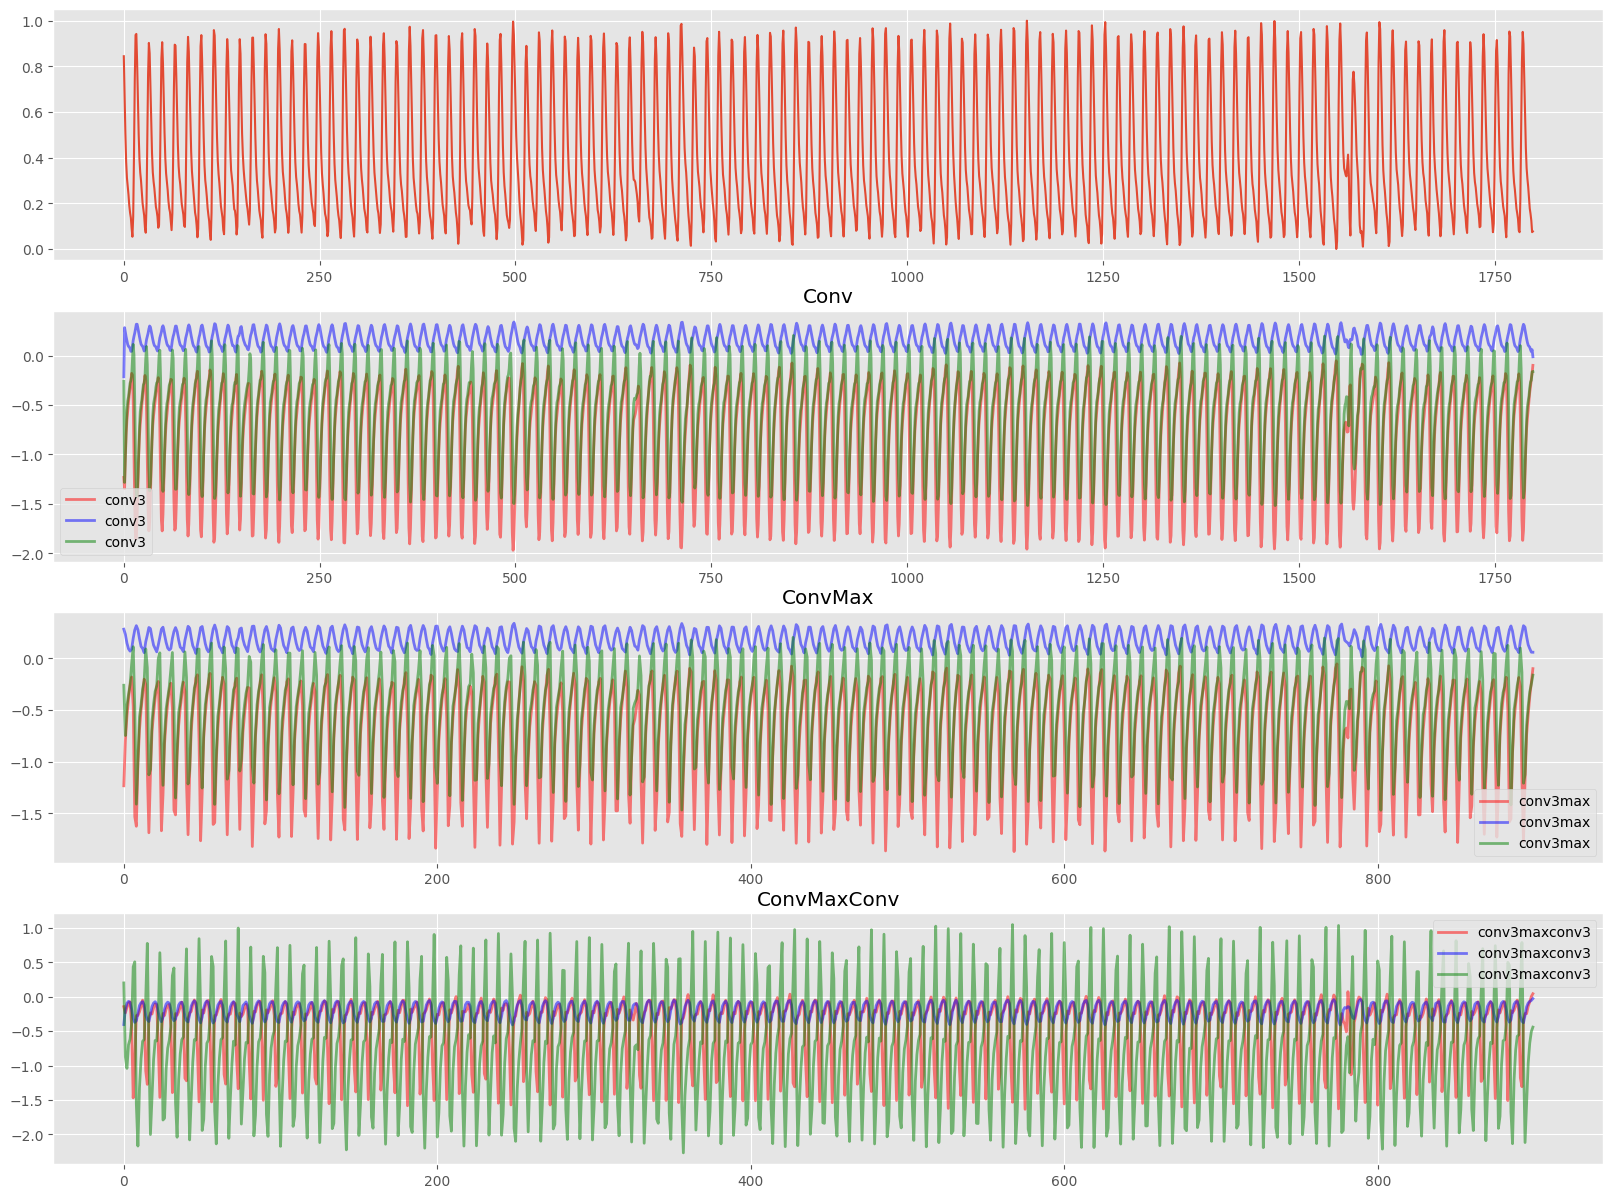

In [16]:
fig, axs = plt.subplots(4,1,figsize=(20,15))
axs[0].plot(test.reshape(-1))
axs[1].plot(tf.reshape(test1_conv3s2, [-1]), alpha=.5, color='r', linewidth=2, label='conv3')
axs[1].plot(tf.reshape(test2_conv3s2, [-1]), alpha=.5, color='b', linewidth=2, label='conv3')
axs[1].plot(tf.reshape(test3_conv3s2, [-1]), alpha=.5, color='g', linewidth=2, label='conv3')
axs[1].legend()
axs[1].set_title('Conv')
axs[2].plot(tf.reshape(test1_conv3s2max2, [-1]), alpha=.5, color='r', linewidth=2, label='conv3max')
axs[2].plot(tf.reshape(test2_conv3s2max2, [-1]), alpha=.5, color='b', linewidth=2, label='conv3max')
axs[2].plot(tf.reshape(test3_conv3s2max2, [-1]), alpha=.5, color='g', linewidth=2, label='conv3max')
axs[2].legend()
axs[2].set_title('ConvMax')
axs[3].plot(tf.reshape(test1_conv3s2max2conv3, [-1]), alpha=.5, color='r', linewidth=2, label='conv3maxconv3')
axs[3].plot(tf.reshape(test2_conv3s2max2conv3, [-1]), alpha=.5, color='b', linewidth=2, label='conv3maxconv3')
axs[3].plot(tf.reshape(test3_conv3s2max2conv3, [-1]), alpha=.5, color='g', linewidth=2, label='conv3maxconv3')
axs[3].legend()
axs[3].set_title('ConvMaxConv')
plt.show()